# RNN model training

Each mini-batch contains $B \times T$ prediction instances for training. 
Prediction is done at each step, with the state updated at each step as well.
Below are logits for $t = 1, \ldots, 30.$ At each step, the hidden state is updated before making the next prediction. Finally, the model is evaluated at every time step with varying-length inputs. State starts at zero, so it may be necessary to warm the model up.

In [1]:
from chapter import *

In [2]:
%%save
def collate_fn(batch):
    """Transforming the data to sequence-first format."""
    x, y = zip(*batch)
    x = torch.stack(x, 1)      # (T, B, vocab_size)
    y = torch.stack(y, 1)      # (T, B)
    return x, y

def collate_fn(batch):
    """Transforming the data to sequence-first format."""
    x, y = zip(*batch)
    x = torch.stack(x, 1)      # (T, B, vocab_size)
    y = torch.stack(y, 1)      # (T, B)
    return x, y

Training on sequences from *The Time Machine*:

In [3]:
from torch.utils.data import random_split

tm = TimeMachine()
corpus, vocab = tm.build()
T = 30
BATCH_SIZE = 128

dataset = SequenceDataset(corpus, seq_len=T, vocab_size=len(vocab))
train_dataset, valid_dataset = random_split(dataset, [0.80, 0.20])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)    # also sampled

print("preds per epoch")
print("train:", f"{len(train_loader) * BATCH_SIZE * T: .3e}")
print("valid:", f"{len(valid_loader) * BATCH_SIZE * T: .3e}")

preds per epoch
train:  4.182e+06
valid:  1.048e+06


When training RNNs, it is common to use **gradient clipping**. RNNs are deep in another sense, i.e. in sequence length since we apply the state update function $f$ for each sequence element. Hence, during BP, we get matrix products of length $O(T).$ This causes gradients to explode or vanish resulting in numerical instability. A direct solution to exploding gradients is simply to clip them. Here we project them to a ball of radius $\xi > 0.$ Thus,

$$
\boldsymbol{\mathsf{g}} \leftarrow \min \left(1, \frac{\xi}{\| \boldsymbol{\mathsf{g}} \|} \right) \boldsymbol{\mathsf{g}} = \min \left({\| \boldsymbol{\mathsf{g}}\|,\, {\xi}} \right) \frac{\boldsymbol{\mathsf{g}}}{\| {\boldsymbol{\mathsf{g}}} \|}.
$$

First, the gradient is still in the same direction but clipped in norm to $\xi.$ 
So when $\| \boldsymbol{\mathsf{g}} \| \leq \xi$, the gradient is unchanged. On the other hand, when 
$\| \boldsymbol{\mathsf{g}} \| > \xi$, the above ratio goes out of the $\min$ operation, and the gradient is scaled to have norm $\xi.$

In [4]:
%%save
import torch.nn.functional as F

def clip_grad_norm(model, max_norm: float):
    """Calculate norm on concatenated params. Modify params in-place."""
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > max_norm:
        for p in params:
            p.grad[:] *= max_norm / norm   # [:] = shallow copy, in-place

import torch.nn.functional as F

def clip_grad_norm(model, max_norm: float):
    """Calculate norm on concatenated params. Modify params in-place."""
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > max_norm:
        for p in params:
            p.grad[:] *= max_norm / norm   # [:] = shallow copy, in-place

PyTorch `F.cross_entropy` expects input `(B, C, T)` and target `(B, T)`:

In [5]:
%%save
def train_step(model, optim, x, y, max_norm) -> float:
    target = y.transpose(0, 1)
    output = model(x).permute(1, 2, 0)
    loss = F.cross_entropy(output, target)
    loss.backward()
    
    clip_grad_norm(model, max_norm=max_norm)
    optim.step()
    optim.zero_grad()
    return loss.item()


@torch.no_grad()
def valid_step(model, x, y) -> float:
    target = y.transpose(0, 1)
    output = model(x).permute(1, 2, 0)
    loss = F.cross_entropy(output, target)
    return loss.item()

def train_step(model, optim, x, y, max_norm) -> float:
    target = y.transpose(0, 1)
    output = model(x).permute(1, 2, 0)
    loss = F.cross_entropy(output, target)
    loss.backward()
    
    clip_grad_norm(model, max_norm=max_norm)
    optim.step()
    optim.zero_grad()
    return loss.item()


@torch.no_grad()
def valid_step(model, x, y) -> float:
    target = y.transpose(0, 1)
    output = model(x).permute(1, 2, 0)
    loss = F.cross_entropy(output, target)
    return loss.item()

Training the model:

In [6]:
from tqdm.notebook import tqdm

DEVICE = "cpu"
LR = 0.01
EPOCHS = 5
MAX_NORM = 1.0

model = LanguageModel(RNN)(len(vocab), 64, len(vocab))
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
valid_losses = []
for e in tqdm(range(EPOCHS)):
    for t, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = train_step(model, optim, x, y, MAX_NORM)
        train_losses.append(loss)

        if t % 5 == 0:
            xv, yv = next(iter(valid_loader))
            xv, yv = xv.to(DEVICE), yv.to(DEVICE)
            valid_losses.append(valid_step(model, xv, yv))

print(np.array(valid_losses)[-5:].mean())

  0%|          | 0/5 [00:00<?, ?it/s]

1.5474418163299561


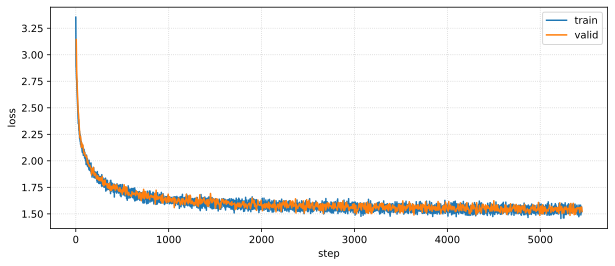

In [7]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="train")
plt.plot(np.array(range(1, len(valid_losses) + 1)) * 5, valid_losses, label="valid")
plt.grid(linestyle="dotted", alpha=0.6)
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

Note we addressed problem of exploding gradients, but not vanishing gradients.

In [8]:
!mkdir -p artifacts/
PATH = "./artifacts/rnn_lm.pkl"
torch.save(model.state_dict(), PATH)